In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12,8)
import numpy as np
import tensorflow as tf
import keras
import pandas as pd

/Users/nsteins/Documents/DeepProduct/env/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [111]:
t = list(tf.python_io.tf_record_iterator('../Data/bal_laugh_speech_subset.tfrecord'))
tf_example = tf.train.Example.FromString(t[0])
tf_example.features.feature['video_id'].bytes_list.value[0].decode()

'CYuSRXwW3r4'

In [116]:
len(t)

18768

In [2]:
from keras.preprocessing.sequence import pad_sequences

def data_generator(batch_size, tfrecord):
    max_len=10
    records = list(tf.python_io.tf_record_iterator(tfrecord))
    rec_len = len(records)
    print(rec_len)
    shuffle = np.random.permutation(range(rec_len))
    num_batches = rec_len//batch_size 
    j = 0

    laugh_labels = [16, 17, 18, 19, 20, 21]
    while True:
        X = []
        y = []
        for idx in shuffle[j*batch_size:(j+1)*batch_size]:
            example = records[idx]
            tf_seq_example = tf.train.SequenceExample.FromString(example)
            example_label = list(np.asarray(tf_seq_example.context.feature['labels'].int64_list.value))
            laugh_bin = any((True for x in example_label if x in laugh_labels))
            y.append(laugh_bin)

            n_frames = len(tf_seq_example.feature_lists.feature_list['audio_embedding'].feature)
            audio_frame = []
            for i in range(n_frames):
                audio_frame.append(np.frombuffer(tf_seq_example.feature_lists.feature_list['audio_embedding'].
                                                         feature[i].bytes_list.value[0],np.uint8).astype(np.float32))
            pad = [np.zeros([128], np.float32) for i in range(max_len-n_frames)]
            audio_frame += pad
            X.append(audio_frame)

        j += 1
        if j >= num_batches:
            shuffle = np.random.permutation(range(rec_len))
            j = 0

        X = np.array(X)
        yield X, y

In [15]:
import itertools
batch_size = 32
val_gen = data_generator(batch_size,'../Data/eval_laugh_speech_subset.tfrecord')
val = list(itertools.islice(val_gen,586//32))
X = [d[0] for d in val]
y = [d[1] for d in val]
X = np.concatenate(X)
y = np.concatenate(y)

586


In [4]:
y.shape

(224,)

In [5]:
from keras.models import load_model
m1 = load_model('../Models/LSTM_trained_on_laugh_speech_audioset_100epoch.h5')

In [16]:
p1 = m1.predict(X)

In [7]:
m2 = load_model('../Models/LSTM_trained_on_audioset_40epoch.h5')

In [17]:
p2 = m2.predict(X)

In [18]:
m3 = load_model('../Models/laugh_speech_full_100.h5')
p3 = m3.predict(X)

In [21]:
m4 = load_model('../Models/lr_100.h5')
p4 = m4.predict(X)

In [33]:
from keras.metrics import top_k_categorical_accuracy

def top_one_accuracy(x, y):
    """Must be passed to `load_model` function in `keras` as a custom_object"""
    return top_k_categorical_accuracy(x, y, k=1)

m5 = load_model('../Models/67top1acc_bidirectional_lstm_dropout_batchnorm_sgd.h5', 
                custom_objects={'<lambda>': top_one_accuracy})
vp5 = m5.predict(X)

/Users/nsteins/Documents/DeepProduct/env/lib/python3.6/site-packages/keras/engine/topology.py:1269: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(gamma_regularizer=None, name="batchnormalization_8", epsilon=0.001, trainable=True, input_dtype="float32", batch_input_shape=[None, 10,..., beta_regularizer=None, momentum=0.99, axis=-1)`
  return cls(**config)
/Users/nsteins/Documents/DeepProduct/env/lib/python3.6/site-packages/keras/engine/topology.py:1269: UserWarning: Update your `Dropout` call to the Keras 2 API: `Dropout(trainable=True, name="dropout_7", rate=0.5)`
  return cls(**config)
/Users/nsteins/Documents/DeepProduct/env/lib/python3.6/site-packages/keras/layers/recurrent.py:2129: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  return cls(**config)
/Users/nsteins/Documents/DeepProduct/env/lib/python3.6/site-packages/keras/layers/recurrent.py:2129: UserWarning: Up

In [34]:
def get_top_class_display_name(output_vector):        
    """Returns the name of the class with the highest activation"""
#     labels = ["laughter", "baby laughter", "giggle", "snicker", \
#     "belly laugh", "chuckle/chortle", "none of the above"]
    labels = [True, True, True, True, True, True, False]
    sorted_indices = list(np.argsort(output_vector)[::-1])
    return labels[sorted_indices[0]]

p5 = [get_top_class_display_name(p) for p in vp5]

In [39]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y,p1)
fpr2, tpr2, thresholds2 = roc_curve(y,p2)
fpr3, tpr3, thresholds3 = roc_curve(y,p3)
fpr4, tpr4, thresholds4 = roc_curve(y,p4)
fpr5, tpr5, thresholds5 = roc_curve(y,1-vp5[:,-1])

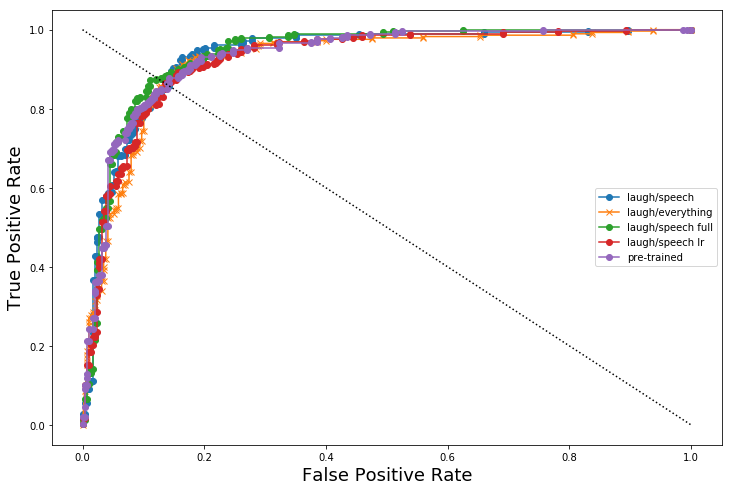

In [40]:
plt.plot(fpr,tpr, 'o-', label='laugh/speech')
plt.plot(fpr2,tpr2, 'x-', label='laugh/everything')
plt.plot(fpr3,tpr3, 'o-', label='laugh/speech full')
plt.plot(fpr4,tpr4, 'o-', label='laugh/speech lr')
plt.plot(fpr5,tpr5, 'o-', label='pre-trained')



plt.plot([0,1],[1,0],'k:')
plt.xlabel('False Positive Rate', size=18)
plt.ylabel('True Positive Rate', size=18)
plt.legend()

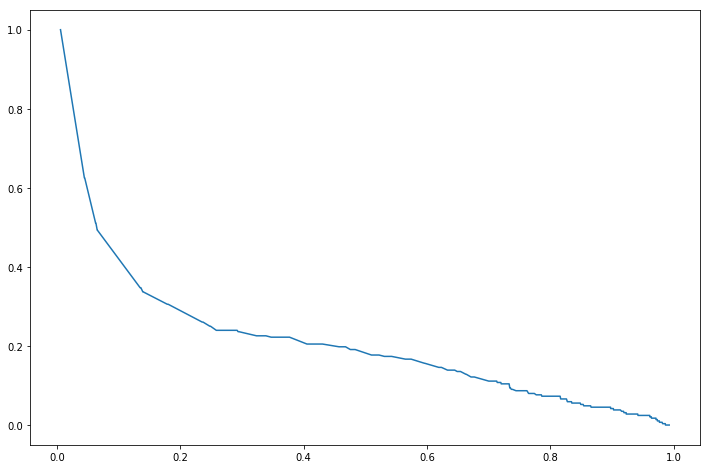

In [42]:
plt.plot(thresholds3,fpr3)

In [85]:
tpr2[8]

0.30136986301369861